In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms,datasets
import numpy as np
import matplotlib.pyplot as plot
import PIL.Image as Image

#自己读取数据集，继承Dataset抽象类，并覆盖相关方法
class Mydataset(Dataset):
    "脸部数据集"
    def __init__(self,path,transform=None):
        self.names=os.listdir(path)
        self.path=path
        self.transform=transform

    def __len__(self):
        return len(self.names)
    # __getitem__用来获取一些索引数据，例如 dataset[i] 中的(i)
    def __getitem__(self,idx):
        path_name=os.path.join(self.path,self.names[idx])
        image=Image.open(path_name) #用PIL会少很多麻烦
        label=int(self.names[idx][5:-4])       
        # tansforms还是需要自己去实现同时处理标签和图片。
        if self.transform:
            image=self.transform(image)
        sample={'image':image,"label":label}
        # return sample
        return image,label


len:  16


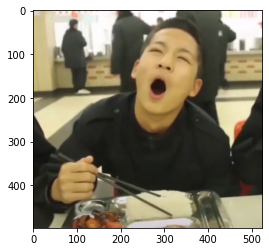

In [4]:
mydataset=Mydataset(path="./faces/sleep")
print("len: ",len(mydataset)) #__len__
img,_=mydataset[0] # __getitem__
plot.imshow(img)
plot.show()

batch:  0


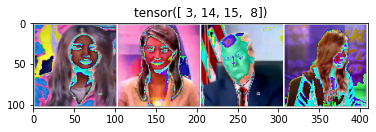

In [6]:
# 全手工读取
dataloader=DataLoader(
    dataset=Mydataset(
        path="./faces/sleep",
        transform=transforms.Compose([
            transforms.Resize((100,100)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
    ),
    batch_size=4,
    shuffle=True,
    # shuffle=False,
    # sampler=torch.utils.data.sampler.WeightedRandomSampler([1]*8,num_samples=10,replacement=True) #不如拥抱ImageFolder方便
)
# for i,batch in enumerate(dataloader):   
#     images=batch['image']
#     labels=batch['label']
for i,(images,labels) in enumerate(dataloader):
    print("batch: ",i)
    grid=torchvision.utils.make_grid(images)
    plot.title(labels)
    plot.imshow(transforms.ToPILImage()(grid))
    plot.show()
    break

batch:  0


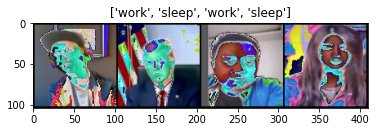

In [8]:
#ImageFolder是更简单暴力常用的类。
#他会读取root="./faces"目录下的所有子文件夹，其中子文件夹名为类名，子文件夹里的图片为类内图片。
#在这个例子里，训练集里有两类work、sleep。（注意，训练集、测试集是一样性质的东西！）
dataset=datasets.ImageFolder(
    root="./faces",
    transform=transforms.Compose([
        transforms.Resize((100,100)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])    
)
classes=dataset.classes # dataset.classes=['sleep', 'work']
dataloader=DataLoader(
    dataset=dataset,
    batch_size=4,
    shuffle=True,
    num_workers=6 #开启几个线程来加载，越大越好，一般设置为cpu核心数
)
#每一类16张，两类混在一起随机读取，共32张，8个batch！
for i,(images,labels) in enumerate(dataloader):
    print("batch: ",i)
    grid=torchvision.utils.make_grid(images)
    plot.title([classes[i] for i in labels]) 
    plot.imshow(transforms.ToPILImage()(grid))
    plot.show()   
    break

In [126]:
dataset.imgs  

[('./faces\\sleep\\sleep1.png', 0),
 ('./faces\\sleep\\sleep10.png', 0),
 ('./faces\\sleep\\sleep11.png', 0),
 ('./faces\\sleep\\sleep12.png', 0),
 ('./faces\\sleep\\sleep13.png', 0),
 ('./faces\\sleep\\sleep14.png', 0),
 ('./faces\\sleep\\sleep15.png', 0),
 ('./faces\\sleep\\sleep16.png', 0),
 ('./faces\\sleep\\sleep2.png', 0),
 ('./faces\\sleep\\sleep3.png', 0),
 ('./faces\\sleep\\sleep4.png', 0),
 ('./faces\\sleep\\sleep5.png', 0),
 ('./faces\\sleep\\sleep6.png', 0),
 ('./faces\\sleep\\sleep7.png', 0),
 ('./faces\\sleep\\sleep8.png', 0),
 ('./faces\\sleep\\sleep9.png', 0),
 ('./faces\\work\\work1.png', 1),
 ('./faces\\work\\work10.png', 1),
 ('./faces\\work\\work11.png', 1),
 ('./faces\\work\\work12.png', 1),
 ('./faces\\work\\work13.png', 1),
 ('./faces\\work\\work14.png', 1),
 ('./faces\\work\\work15.png', 1),
 ('./faces\\work\\work16.png', 1),
 ('./faces\\work\\work2.png', 1),
 ('./faces\\work\\work3.png', 1),
 ('./faces\\work\\work4.png', 1),
 ('./faces\\work\\work5.png', 1),
 (

batch:  0


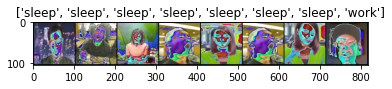

In [9]:
#如果数据分布不均衡，可以自定义采样函数进行随机打乱采样。replacement表示可以重复采样某一数据
weights=[9 if label == 0 else 1 for data,label in dataset.imgs] #sleep权值较大  # dataset.imgs取出path、label
sampler=torch.utils.data.sampler.WeightedRandomSampler(weights,num_samples=10,replacement=True)
dataloader=DataLoader(dataset,batch_size=8,shuffle=False,sampler=sampler) #ImageFolder
for i,(images,labels) in enumerate(dataloader):
    print("batch: ",i)
    grid=torchvision.utils.make_grid(images)
    plot.title([classes[i] for i in labels])
    plot.imshow(transforms.ToPILImage()(grid))
    plot.show()   
    break

batch:  0


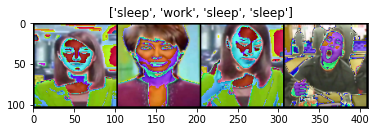

In [11]:
def detection_collate(batch):
    #自定义如何拾取数据。例如目标不同图有不同数目个bounding box，即1图对应多标签！更复杂的用到时再说。
    # mask啥的也可以用这个获取。。
    # 甚至可以在这里预处理数据？虽然没必要
    """Custom collate fn for dealing with batches of images that have a different
    number of associated object annotations (bounding boxes).

    Arguments:
        batch: (tuple) A tuple of tensor images and lists of annotations

    Return:
        A tuple containing:
            1) (tensor) batch of images stacked on their 0 dim
            2) (list of tensors) annotations for a given image are stacked on
                                 0 dim
    """
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0]) #img
        targets.append(sample[1]) #label
    return torch.stack(imgs, 0), targets #返回值需要时imgs，labels

dataloader=DataLoader(dataset,batch_size=4,shuffle=True,collate_fn=detection_collate) #ImageFolder
for i,(images,labels) in enumerate(dataloader):
    print("batch: ",i)
    grid=torchvision.utils.make_grid(images)
    plot.title([classes[i] for i in labels])
    plot.imshow(transforms.ToPILImage()(grid))
    plot.show()   
    break